## Analysis of Wikipedia usage and tweets from normal daily users


In this first part, we want to randomly retrieve tweets posted by people in the early stage of the pandemic in order to analyse how COVID-19 affected people's interests and the role of social media as communication platforms. The way we use to retrieve tweets
aims at obtaining a sample which is the least possible biased. After retrieving data for each country (in this first analysis
we start with Serbia and Italy, out homelands, to test the scalability and feasibility of our ideas), we want to classify them according to
the topic they present. We are interested in analysing which have been the most discussed topics to see if we get result
similar to those shown in CoronaWiki dataset. We think this is a good way to start analysing how people's interests shifted, how people reacted to the situation and how communication has been affected by COVID-19.

We are retrieving tweets posted during the 3 weeks preceding the lockdown in each country because we want to study what was the initial response of the population to the inusual situation. 

In [1]:
# Useful libraries
import pandas as pd
import json
import re
import pickle
from datetime import datetime, timedelta

# Twitter library
import tweepy

# Math libraries
import numpy as np

#Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Natural language processing libraries
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from textblob import TextBlob # to compute sentiment analysis on each tweet
import translators as ts
import warnings

nltk.download('stopwords')

# Libray to infer the topics discussed in each tweet
from empath import Empath
lexicon = Empath()

# Helpers file
from helpers import *

Using state Vaud server backend.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/skocko/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Tweets datase creation - Italy & Serbia

We start by creating lists containing the names of the analysed countries and the spoken languages.

In [2]:
# We define lists containing the names and the spoken languages in each country
# France, Denmark, Germany, Italy, Netherlands, Normway, Sweden, Serbia, Finland, UK
total_countries = ['FR','DK','DE','IT','NL','NO','SE','RS','FI','GB']
total_languages = ['fr','da','de','it','nl','no','sv','sr','fi','en']
analysed_countries = ['IT','RS']
analysed_languages = ['it','sr']
period_per_countries = {}

In order to compute our analysis, we need to define a period of time during the pandemic. We use pagelogs and intervention data in order to define this period of interest for each country. We retrieved data during the 3 weeks preceding the lockdown, since we are interested in analyzing human reactions and behaviour during the first stage of the pandemic.

In [3]:
# Importing pagelogs time series
data_path = './data/'
with open(data_path + 'aggregated_timeseries.json','r') as file:
    pagelogs_time_series = json.load(file)

In [4]:
# Importing intervention dates for each country
interventions = pd.read_csv(data_path + 'interventions.csv', delimiter=',', 
                            parse_dates=['1st case','1st death','School closure',
                                           'Public events banned','Lockdown','Mobility','Normalcy'])

interventions.set_index('lang', inplace=True)
interventions

,1st case,1st death,School closure,Public events banned,Lockdown,Mobility,Normalcy
lang,,,,,,,
fr,2020-01-24,2020-02-14,2020-03-14,2020-03-13,2020-03-17,2020-03-16,2020-07-02
da,2020-02-27,2020-03-12,2020-03-13,2020-03-12,2020-03-18,2020-03-11,2020-06-05
de,2020-01-27,2020-03-09,2020-03-14,2020-03-22,2020-03-22,2020-03-16,2020-07-10
it,2020-01-31,2020-02-22,2020-03-05,2020-03-09,2020-03-11,2020-03-11,2020-06-26
nl,2020-02-27,2020-03-06,2020-03-11,2020-03-24,NaT,2020-03-16,2020-05-29
no,2020-02-26,2020-02-26,2020-03-13,2020-03-12,2020-03-24,2020-03-11,2020-06-04
sr,2020-03-06,2020-03-20,2020-03-15,2020-03-21,2020-03-21,2020-03-16,2020-05-02
sv,2020-01-31,2020-03-11,2020-03-18,2020-03-12,NaT,2020-03-11,2020-06-05
ko,2020-01-20,2020-02-20,2020-02-23,NaT,NaT,2020-02-25,2020-04-15


In [5]:
# Defining period of interest for each country. Dates refered to 3 weeks before the lockdown
lockdown_dates = [interventions.loc[lang, 'Lockdown'] for lang in analysed_languages]

for idx,country in enumerate(analysed_countries):
    lang = analysed_languages[idx]
    dates = [datetime.strptime(date.split()[0], '%Y-%m-%d') for date in list(pagelogs_time_series[lang]['sum'].keys())]
    dates = [date for date in dates if (lockdown_dates[idx] - date < timedelta(21)) and 
             (lockdown_dates[idx] - date >  timedelta(0))]
    period_per_countries[country] = dates

We want to retrieve tweets on a daily basis. In order to reduce the bias in our data, we decide to retrieve tweets in different moments of the day which are randomly chosen. Since most of the activity was during the afternoon, we want to give more weights to these hours. 

In [6]:
# Defining a hour time window to retrieve data
hours = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
# We want to give more weights to part of the day closer to dinner / late afternoon. So we assign them a higher weights
weights = np.ones(len(hours)) / 15
weights[-5:] = weights[-5:] * 2

Since we are interested in finding analogies between the topics discussed on Twitter and the pages visited on Wikipedia, we need to define a list of topics with respect to which we are going to classify each retrieved tweet. In order to do so, we use the file 'topics_linked.csv'. Considering that we use empath library to compute the classification of each text, we define a set of topics which is as equivalent as possible to the one reported in the file.

In [7]:
provided_topics = pd.read_csv('./Data/topics_linked.csv', delimiter=',')
provided_topics.columns

Index(['index', 'Geography.Regions.Asia.Central Asia',
       'Geography.Regions.Europe.Eastern Europe',
       'History and Society.Military and warfare', 'Culture.Media.Television',
       'History and Society.Education', 'Culture.Media.Books',
       'Geography.Regions.Africa.Africa*', 'Culture.Visual arts.Architecture',
       'Culture.Biography.Women', 'Geography.Regions.Americas.North America',
       'STEM.STEM*', 'Culture.Performing arts', 'Culture.Literature',
       'History and Society.Politics and government',
       'Geography.Regions.Africa.Northern Africa',
       'STEM.Earth and environment', 'Geography.Regions.Africa.Central Africa',
       'STEM.Medicine & Health', 'STEM.Libraries & Information',
       'Geography.Regions.Europe.Europe*',
       'Geography.Regions.Europe.Western Europe', 'Culture.Media.Radio',
       'STEM.Space', 'Culture.Visual arts.Comics and Anime', 'STEM.Technology',
       'Culture.Internet culture', 'Culture.Media.Software',
       'Geography.R

After reading the categories offered by empath library at  https://github.com/Ejhfast/empath-client/blob/master/empath/data/categories.tsv, we report the ones we decide to use.

In [8]:
topics = ['help', 'medical_emergency', 'health', 'government', 'school', 'kill', 'art', 'play', 'computer',
         'home', 'business', 'religion', 'sports', 'military', 'music', 'science', 'fun', 'economics',
         'technology', 'philosophy', 'geography', 'tv', 'architecture']

We also define a list of feelings and emotions that we want to detect in each tweet to perceive the general sentiment n the population. This method performs better than a simple sentiment analysis since it better catches the semantic power of each used word.

In [9]:
emotions = ["suffering", "optimism", "fear", "sadness", "joy", "anger", "pain", "negative_emotion", 
            "positive_emotion", "happiness"]

We now proceed to define two helper functions to create and import the needed dataframes. As said before, we start working on tweets posted by italian and serbian people to verify the goodness of our approach. For Milestone3, we will focus on a bigger number of countries.
Notice that, in order to filter the tweets we retrieve, we set a very specific query.

#### Retrieving tweets from Italy and Serbia

After creating the dataset for italian tweets (done in advance dealing with Twitter API rate limit), we import it to analyze not only the topics contained in tweeets, but also the emotions that we can retreive and perceive from them.

In [10]:
# Importing Italy data
# The following dataset was created by using 'create_dataframe' function inside helpers.py
italian_tweets = pd.read_pickle('./output/' + 'IT' + '_tweets.pkl')

We now proceed to plot the most discussed topics based on the classification made using empath library. Obviously the normalized score is low (since translation is not always optimal) but we notice that, in addition to sports,school and government (which are tipical topics discussed on Twitter), medical emergency, help and death are new concepts that seem to start being widely discussed by people.

In [11]:
def plot_categories(data, topics, name_country):
    """
    Function which plot most common emotions/topics in retrieved tweets
    
    Arguments:
        data: dataset with tweets
        topics: list of topics/emotions
        name_country: name of country from which we are retrieving tweets
    """
    fig,ax = plt.subplots(1)

    # We infer the topics discussed in the retrieved tweets
    classified_topics = pd.DataFrame([lexicon.analyze(data.tweet.str.cat(sep=' '),categories=topics, 
                                                  normalize=True)], index=[name_country]).T

    classified_topics = classified_topics.sort_values(by=[name_country], ascending=False)
    classified_topics.reset_index(inplace=True)
    sns.barplot(data = classified_topics, x=name_country, y='index')
    plt.title('Topics discussed in {} during the 3 weeks preceding the official lockdown'.format(name_country), pad=10)
    plt.ylabel('Categories', fontsize=12)
    plt.xlabel('Normalized Score', fontsize=12)

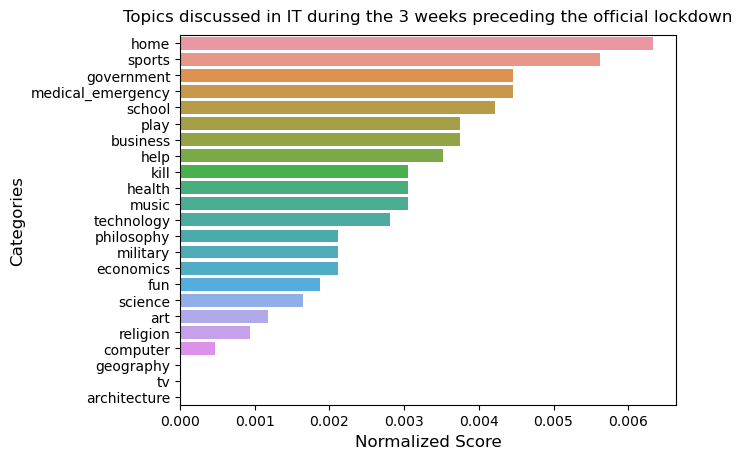

In [12]:
plot_categories(italian_tweets,topics,'IT')

We notice that the interest each topic receives (represented by the score) is also very similar to the number of pagelogs the very same topic received during the same period. Moreover, it is worth noticing how more discussed topics on Twitter seem to receive on average a larger number of visits in the same period: government and medical emergency, that are really close in the above graph, belong to two categories (politics and medicine) that prove to be very close also in terms of Wikipedia visits.

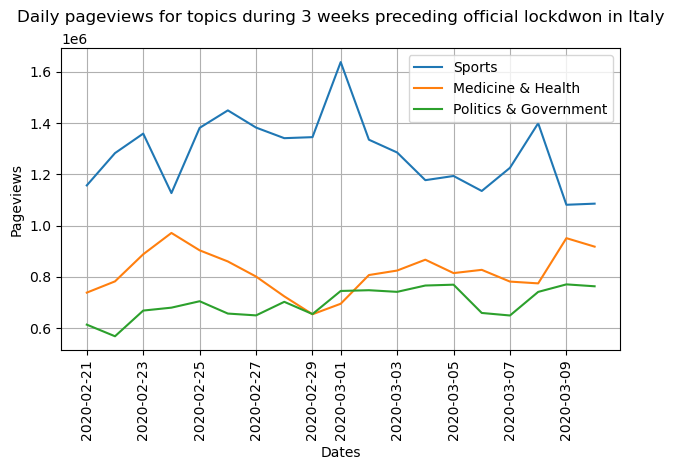

In [13]:
# We need to retrieve pageviews log from mobile and from pc
# We know that keys for mobile and not mobile are the same

keys = list(pagelogs_time_series['it']['topics']['Culture.Sports']['sum'].keys())
keys = np.array(list(map(lambda x : datetime.strptime(x.split()[0], '%Y-%m-%d'), keys)))

# Sports
sports_nm = list(pagelogs_time_series['it']['topics']['Culture.Sports']['sum'].values())
sports_m = list(pagelogs_time_series['it.m']['topics']['Culture.Sports']['sum'].values())
sports = list(map(lambda x,y : x + y, sports_nm, sports_m))

# Health
health_nm = list(pagelogs_time_series['it']['topics']['STEM.Medicine & Health']['sum'].values())
health_m = list(pagelogs_time_series['it.m']['topics']['STEM.Medicine & Health']['sum'].values())
health = list(map(lambda x,y : x + y, health_nm, health_m))

# Politics
politics_nm = list(pagelogs_time_series['it']['topics']['History and Society.Politics and government']['sum'].values())
politics_m = list(pagelogs_time_series['it.m']['topics']['History and Society.Politics and government']['sum'].values())
politics = list(map(lambda x,y : x + y, politics_nm, politics_m))

index_for_our_period = ( keys > period_per_countries['IT'][0] ) & ( keys <= period_per_countries['IT'][-1] )
keys = keys[index_for_our_period]
sports = np.array(sports)[index_for_our_period]
health = np.array(health)[index_for_our_period]
politics = np.array(politics)[index_for_our_period]
plt.plot( keys, sports, label='Sports')
plt.plot( keys, health, label='Medicine & Health')
plt.plot( keys, politics, label='Politics & Government')
plt.title('Daily pageviews for topics during 3 weeks preceding official lockdwon in Italy', pad=19)
plt.xticks(rotation=90)
plt.xlabel('Dates')
plt.ylabel('Pageviews')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

We now want to understand which emotions can be perceived from these tweets. We use an approach similar to the previous one.

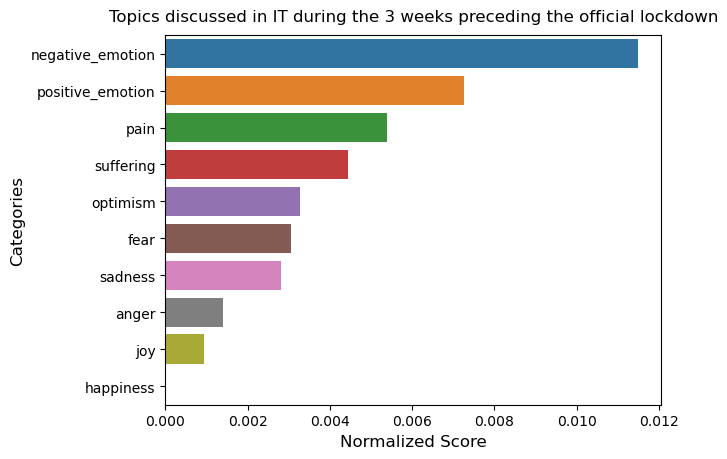

In [14]:
# We infer the topics discussed in the retrieved tweets
plot_categories(italian_tweets,emotions, 'IT')

In [15]:
# Importing Serbia data
# The following dataset was created by using 'create_dataframe' function inside helpers.py
serbian_tweets = pd.read_pickle('./output/' + 'RS' + '_tweets.pkl')

serbian_tweets.sample(6)

,date,id,language,tweet,tokenized_tweet_list,context_from_Twitter,polarity,subjectivity
54,2020-03-20,1241054730291421184,sr,aman people sit at your homes and dont go out ...,"[aman, peopl, sit, at, your, home, and, dont, ...",[],-0.40000,0.600000
21,2020-03-09,1236985420438740992,sr,and this when you glorify the average normal t...,"[and, thi, when, you, glorifi, the, averag, no...",[],-0.25000,0.641667
31,2020-03-14,1238809422882799616,sr,the heroes and profiteers know each other,"[the, hero, and, profit, know, each, other]",[],-0.12500,0.375000
49,2020-03-19,1240690391394836480,sr,both external and internal policy is reduced t...,"[both, extern, and, intern, polici, is, reduc,...",[],0.00000,0.050000
8,2020-03-07,1236308043232673799,sr,ahazubuazaz i reduced the case to the end ever...,"[ahazubuazaz, i, reduc, the, case, to, the, en...",[],-0.35625,0.643750
23,2020-03-03,1234949368165421056,sr,this christodule needs to be abused \n what a ...,"[thi, christodul, need, to, be, abus, what, a,...",[],0.00000,0.000000


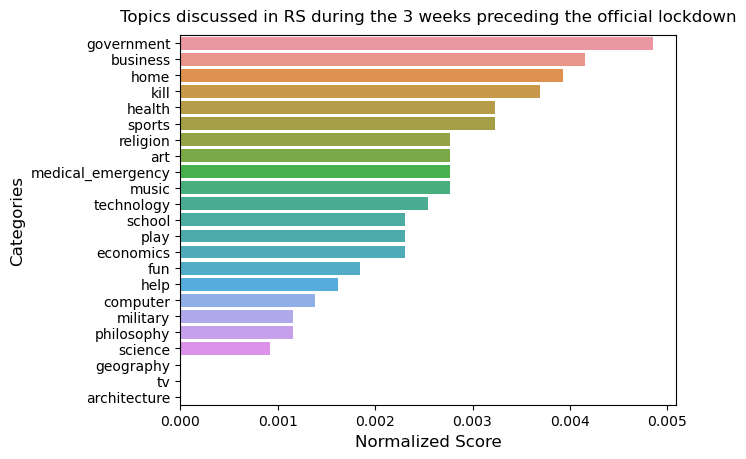

In [16]:
plot_categories(serbian_tweets,topics, 'RS')

From the previous plot we notice that, similarly to Italy, business and politics prove to be widely discussed topics. Moreover it is worth noticing how medical emergency covers a lower place in the final ranking. This might be due to the fact that, as intervention dates suggest, COVID-19 effects seemed to appear in Serbia later than in most of the other european countries. 1st death and 1st infection dates are very shifted if compared to the correspondng dates in other countries.

In [17]:
# Importing death and infection data
data_folder = './Data/'
file_name = 'WHO-COVID-19-global-data.csv'
WHO_df = pd.read_csv(data_folder + file_name, parse_dates = ['Date_reported'])

In [18]:
# Collecting data about Italy and Serbia

df_italy = WHO_df.loc[WHO_df['Country_code']=='IT']
df_serbia = WHO_df.loc[WHO_df['Country_code']=='RS']

df_italy_interval1 = df_italy.loc[(df_italy['Date_reported']>='2020-02-20') & (df_italy['Date_reported']<='2020-03-20')]
df_serbia_interval1 = df_serbia.loc[(df_serbia['Date_reported']>='2020-02-20') & (df_serbia['Date_reported']<='2020-03-20')]

In [19]:
# Defining overall population in the countries
serbian_population = 6844000
italian_population = 59070000

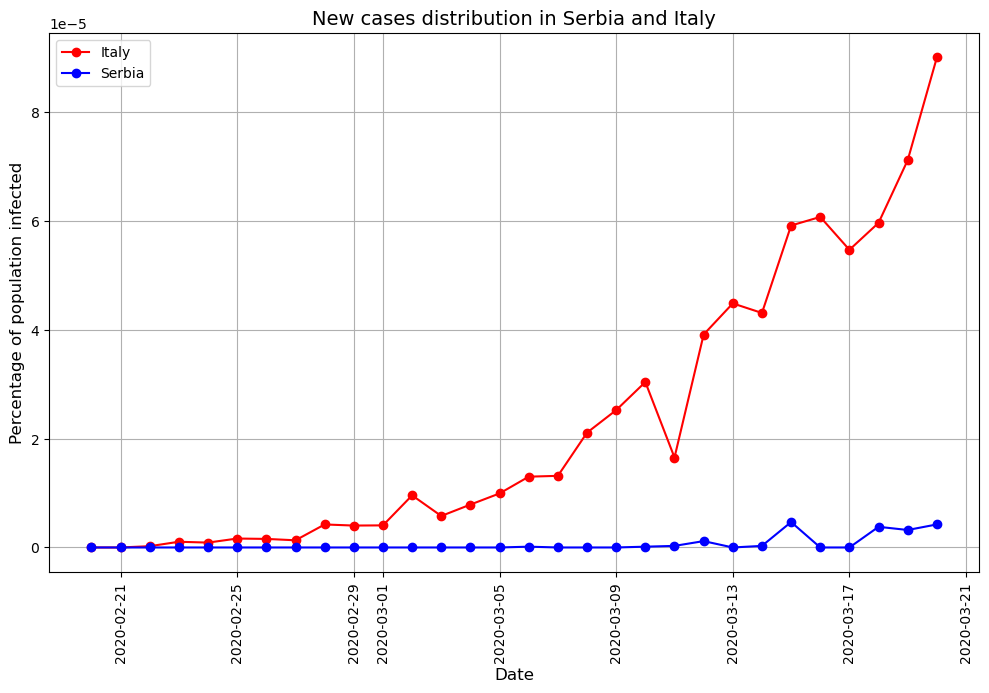

In [20]:
# Plotting number of new cases in Serbia nd Italy from 21.02 - 21.03
plt.figure(figsize=(12,7))

plt.plot(df_italy_interval1['Date_reported'],df_italy_interval1['New_cases']/italian_population,'-ro', label='Italy')
plt.plot(df_serbia_interval1['Date_reported'],df_serbia_interval1['New_cases']/serbian_population, '-bo', label='Serbia')

plt.xlabel('Date', fontsize=12)
plt.ylabel('Percentage of population infected', fontsize=12)
plt.title('New cases distribution in Serbia and Italy', fontsize=14)
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.show()

The result we had from the previous analysis can be justified by this plot. In fact we can see from it that the percentage of population that was infected in Italy and in Serbia was completely different. This could be one of the motivation why in Italy we have more discussions about *medical and health* than in Serbia. This should be investigated more in the third milestone.